# User Input Variables

In [1]:
import datetime

# desired max number of stocks to be recommended to invest in
max_num_stocks = 10

# length of time user plans to hold these stocks before selling
investment_window_days = 30

# end date is today. This should not be changed by the user.
end_date = datetime.datetime.now().date()

# start date indicating how far back to look at historical data of stocks
start_date = end_date - datetime.timedelta(days=365 * 2)

# end user input variables

In [2]:
# install packages

! pip3 install yahoo_fin -U
! pip3 install multiprocess
! pip3 install pyarrow

# ML packages
! pip3 install keras==2.4.3
! pip3 install tensorflow

Requirement already up-to-date: yahoo_fin in c:\users\katri\anaconda3\lib\site-packages (0.8.9.1)


In [3]:
# import libraries and functions

import json
import pandas as pd
import numpy as np
from yahoo_fin import stock_info
import yahoo_fin

from multiprocessing import Pool
import multiprocess as mp
from collections import Counter

import itertools
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import math
from numpy.linalg import multi_dot
import scipy.stats as st

In [4]:
# import get_historical_data function from get_historical_data.py
from get_historical_data import get_historical_data

# get historical stock price data
def get_historical_data_batch(tickers, start_date, end_date):
    historical_data = []
    with Pool(32) as p:
        historical_data = p.map(get_historical_data, tickers)
    return historical_data

In [5]:
%%time

# pull S&P 500 ticker names from stock_info function and save in list called "tickers"
tickers = stock_info.tickers_sp500()

# if '--' is the null ticker, remove it
if '--' in tickers:
    tickers.remove('--')

# store historical stock price data
historical_data = get_historical_data_batch(tickers, start_date, end_date)


Wall time: 36.8 s


In [6]:
%%time

# get a filter for some of the historical data
ticker_to_historical_data = {ticker_table['ticker'].iloc[0]: ticker_table.sort_values('date')
                             for ticker_table in historical_data if not isinstance(ticker_table, tuple)}

# build indexes and unique dates
unique_dates = sorted(set(itertools.chain.from_iterable([table['date'] for table in ticker_to_historical_data.values()])))
unique_dates = np.array(unique_dates, dtype='datetime64[D]')
date_to_index = {date: index for index, date in enumerate(unique_dates)}

ticker_to_index = {ticker: index for index, ticker in enumerate(sorted(list(ticker_to_historical_data.keys())))}

# initialize the data matrix to a bunch of zeros
ticker_data_matrix = np.zeros((len(tickers), len(unique_dates)), dtype=np.float)

# fill the matrix with data
for ticker, ticker_data_table in ticker_to_historical_data.items():
    ticker_index = ticker_to_index[ticker]
    ticker_dates = np.array(ticker_data_table['date'], dtype='datetime64[D]')
    
    date_indexes = np.array([date_to_index[cur_date] for cur_date in ticker_dates])
    price_data = ticker_data_table['close'].values
    ticker_data_matrix[ticker_index, date_indexes] = price_data
    
# there's some nan values in the data, write them as zero
ticker_data_matrix = np.nan_to_num(ticker_data_matrix)


Wall time: 2.35 s


In [7]:
%%time

# number of unique dates is different from the SNP 500 data.
log_price_matrix = np.copy(ticker_data_matrix)
log_price_matrix[np.where(log_price_matrix != 0)] = np.log(log_price_matrix[np.where(log_price_matrix != 0)])

# fit the log stuff with interpolation
x_values = np.array(list(range(log_price_matrix.shape[-1])))
for i, time_series in enumerate(log_price_matrix):
    mask = time_series != 0
    # if there are no non-zero values, give up
    if not np.any(mask):
        continue
    interp_x_values = x_values[mask]
    interp_y_values = time_series[mask]
    log_price_matrix[i] = np.interp(x_values, interp_x_values, interp_y_values)


Wall time: 46.7 ms


In [8]:
start_date = (datetime.datetime.now() - datetime.timedelta(days=365)).date()
end_date = datetime.datetime.now().date()

print("Start date: ", start_date, "\nEnd date: ", end_date)

# calculate mean and covariance
def compute_mean_variance(start_date, end_date):
    sorted_dates = sorted(date_to_index.keys())
    first_date_index = np.searchsorted(sorted_dates, start_date) + 1
    last_date_index = np.searchsorted(sorted_dates, end_date)
    print("First date index: ", first_date_index, "\nLast date index: ", last_date_index)
    
    date_matrix = log_price_matrix[:, first_date_index: last_date_index]
    date_diffs = date_matrix[:, 1:] - date_matrix[:, :-1]
    
    means = np.mean(date_diffs, axis=1)
    covariance = (np.dot(date_diffs, date_diffs.T) / (date_diffs.shape[1] ** 1)) - np.outer(means, means)
    
    return means, covariance

means, covariance = compute_mean_variance(start_date, end_date)

Start date:  2020-09-22 
End date:  2021-09-22
First date index:  253 
Last date index:  504


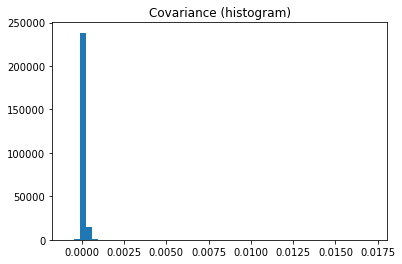

In [9]:
# plot flattened covariance array

plt.hist(covariance.flatten(), bins=50)
plt.title('Covariance (histogram)')
plt.show()

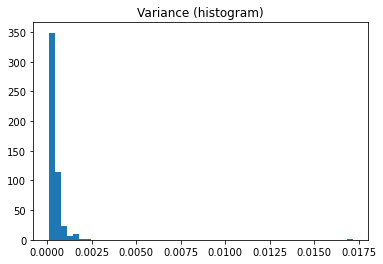

In [10]:
# variance is the diagonal of covariance matrix

plt.hist(np.diag(covariance), bins=50)
plt.title('Variance (histogram)')
plt.show()

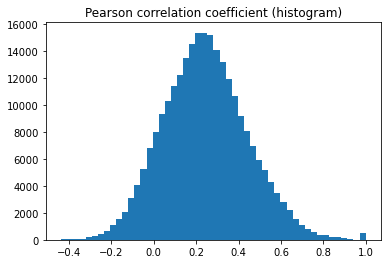

In [11]:
# calculate and plot Pearson correlation coefficient (normalized covariance)
pearsons = [covariance[i, j] / np.sqrt(covariance[i, i] * covariance[j, j])
            for i in range(covariance.shape[0]) for j in range(covariance.shape[1])]
plt.hist(pearsons, bins=50)
plt.title('Pearson correlation coefficient (histogram)')
plt.show()

In [12]:
output_data = {
    'ticker_to_index': ticker_to_index,
    'mean_vector': means.tolist(),
    'covariance_matrix': covariance.tolist()
}

# save output data to a text file
output_data = json.dumps(output_data, indent=4, sort_keys=True)

with open('tmp.txt', 'w') as file:
    file.write(output_data)
    file.flush()

In [13]:
# load the data from the text file
json_data = json.loads(open('tmp.txt', 'r').read())

# load the covariance matrix, mean vector, and ticker to index data to the corresponding arrays
covariance_matrix = np.array(json_data['covariance_matrix'])
mean_vector = np.array(json_data['mean_vector'])
ticker_to_index = json_data['ticker_to_index']

# create dictionary that corresponds index to stock ticker
index_to_ticker = {v: k for k, v in ticker_to_index.items()}

In [14]:
# alpha is the mean
# sigma is the variance along the diagonal
# k is the covariance matrix

alpha = mean_vector * investment_window_days
sigma = np.diag(covariance_matrix) * investment_window_days
k = covariance_matrix * investment_window_days

In [15]:
# element-wise math

# square every term in alpha and sigma
alpha_element_squared = alpha * alpha
sigma_element_squared = sigma * sigma

In [16]:
# invert covariance matrix k
k_inv = np.linalg.inv(k)

# calculate r_opt using formula 3.10 from 
# https://maslov.bioengineering.illinois.edu/optimal_investment_ijtaf.pdf
r_opt = np.dot(k_inv, alpha)


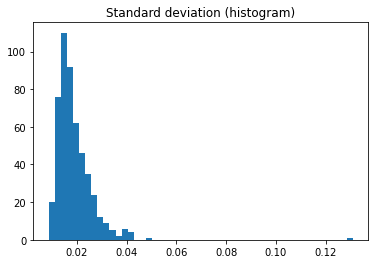

In [17]:
# square root of variance (diagonal of covariance matrix) is standard deviation

plt.hist(np.sqrt(np.diag(covariance_matrix)), bins=50)
plt.title('Standard deviation (histogram)')
plt.show()

In [18]:
# using line search to find lambda

# upper bound, we know that if lambda causes all of the terms to be zero, we went too far.
# i.e., alpha_i - upper_bound_lambda <= 0 \forall i
upper_bound_lambda = np.max(alpha)

# lower bound, we know that each term in the sum is >= 0 and <= the total sum term.
# so just find the lower bound of each term and take the maximum out of all of these terms
# for each term, lambda = alpha_i - alpha_i^2 - sigma_i^2

lower_bound_lambda = np.min(alpha - (alpha_element_squared + sigma_element_squared))

print(f"Lower bound lambda: {lower_bound_lambda}")
print(f"Upper bound lambda: {upper_bound_lambda}")

# now line search/binary search to find lambda

# first we need to evaluate the value of the summation expression in formula 3.12
# https://maslov.bioengineering.illinois.edu/optimal_investment_ijtaf.pdf

# evaluation of expression, f(lambda)
def eval_expression(lambda_value):
    # subtract one so I can get something like \sum - 1 = 0 to solve.
    fractional_terms = (alpha - lambda_value) / (alpha_element_squared + sigma_element_squared)
    
    # heavyside function
    fractional_terms = np.maximum(fractional_terms, 0)
    
    return np.sum(fractional_terms) - 1

# sanity check, the correct value (0) is between the upper bound and lower bound
print(f"Performing a check that 0 is between the evaluation of lower bound lambda ({eval_expression(lower_bound_lambda)})")
print(f"and the evaluation of upper bound lambda ({eval_expression(upper_bound_lambda)})\n")

# tolerance term
tolerance = 1e-9

# initialize our loop with our initial guess for our line search
lower_lambda = lower_bound_lambda
upper_lambda = upper_bound_lambda
middle_lambda = (lower_bound_lambda + upper_bound_lambda) / 2

iterations = 0

# while loop continues while the evaluation of the expression is greater than the tolerance
while np.abs(eval_expression(middle_lambda)) > tolerance:
    # evaluate the expression with updated lambda
    middle_value = eval_expression(middle_lambda)
    
    # if eval of expression (middle_value) is > 0, then lambda guess is too small. Middle lambda becomes new lower lambda.
    if middle_value > 0:
        lower_lambda = middle_lambda
    
    # else, lambda guess is too large. Middle lambda becomes new upper lambda.
    else:
        upper_lambda = middle_lambda
        
    # new middle lambda is halfway between lower and upper lambda
    middle_lambda = (lower_lambda + upper_lambda) / 2

    iterations += 1
    print(f'Iteration: {iterations}\nLambda: {middle_lambda}\nEvaluation of expression: {eval_expression(middle_lambda)}\n')


Lower bound lambda: -0.04032743093029928
Upper bound lambda: 0.3409979716520351
Performing a check that 0 is between the evaluation of lower bound lambda (57243.667109380665)
and the evaluation of upper bound lambda (-1.0)

Iteration: 1
Lambda: 0.2456666210064515
Evaluation of expression: -0.75

Iteration: 2
Lambda: 0.19800094568365972
Evaluation of expression: -0.22609572904326314

Iteration: 3
Lambda: 0.17416810802226382
Evaluation of expression: 0.2883942928963983

Iteration: 4
Lambda: 0.18608452685296178
Evaluation of expression: 0.031149281926567296

Iteration: 5
Lambda: 0.19204273626831075
Evaluation of expression: -0.09747322355834798

Iteration: 6
Lambda: 0.18906363156063627
Evaluation of expression: -0.03316197081589034

Iteration: 7
Lambda: 0.18757407920679903
Evaluation of expression: -0.0010063444446615222

Iteration: 8
Lambda: 0.1868293030298804
Evaluation of expression: 0.015071468740952776

Iteration: 9
Lambda: 0.18720169111833973
Evaluation of expression: 0.007032562148

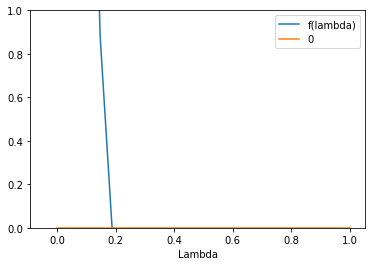

In [19]:
# plot to confirm correct lambda value
# intersection of 0 and f(lambda) indicates correct lambda value

# 101 evenly spaced points between lower bound lambda and upper bound lambda
x = np.linspace(lower_bound_lambda, upper_bound_lambda, 101)

# evaluate each of these 101 points and plot them, f(lambda)
plt.plot(x, [eval_expression(el) for el in x], label='f(lambda)')

# plot 0
plt.plot([0, 1], [0, 0], label='0')

plt.legend()
plt.xlabel('Lambda')
plt.ylim([0,1])

plt.show()

# Final Output

In [20]:
# get the optimal investment portfolio. Formula 3.11
r_opt = np.maximum(0, (alpha - middle_lambda) / (alpha_element_squared + sigma_element_squared))

# flatten r_opt array. Collapse into one dimension.
r_opt = r_opt.flatten()

# store indices of best stocks (stocks with largest recommended investment portions)
best_stock_indices = np.argsort(-r_opt)[:max_num_stocks]

# use the best stock indices to pull the recommend investment ratios/portions of these best stocks
best_stock_prices = r_opt[best_stock_indices]

# normalize best stock proportions so they add up to 1
best_stock_prices /= np.sum(best_stock_prices)

# create an array with each best stock ticker listed with the corresponding investment portion
r_opt_top_stocks_with_names = []
for best_stock_price, best_stock_index in zip(best_stock_prices, best_stock_indices):
    r_opt_top_stocks_with_names.append([best_stock_price, index_to_ticker[best_stock_index]])

print ('\033[1m' + '\033[4m' + 'Suggested investment proportions')
r_opt_top_stocks_with_names


Suggested investment proportions


[[0.5975339998826027, 'MRNA'],
 [0.40246600011739747, 'GE'],
 [0.0, 'NWL'],
 [0.0, 'NVR'],
 [0.0, 'NVDA'],
 [0.0, 'NUE'],
 [0.0, 'NTRS'],
 [0.0, 'NTAP'],
 [0.0, 'NSC'],
 [0.0, 'NRG']]

In [21]:
# calculate mean, variance, and standard deviation of expected return
expected_val = np.dot(r_opt, alpha)
variance = multi_dot([r_opt.T, covariance_matrix, r_opt])
standard_dev = np.sqrt(variance)

print("Mean/expected total return: ", expected_val)
print("Variance: ", variance)
print("Standard dev: ", standard_dev, "\n")

# Calculating confidence intervals:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html

for confidence_level in [0.99, 0.95, 0.85]:
    error = abs(st.norm.ppf((1-confidence_level)/2)) * standard_dev
    print(f"{confidence_level * 100}% confidence interval: {expected_val}", u"\u00B1", error)


Mean/expected total return:  0.2681207353930809
Variance:  0.003454334847975773
Standard dev:  0.05877358971490318 

99.0% confidence interval: 0.2681207353930809 ± 0.15139073466240788
95.0% confidence interval: 0.2681207353930809 ± 0.11519411908334397
85.0% confidence interval: 0.2681207353930809 ± 0.08460643205462787
